In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import os
import matplotlib.pyplot as plt
# import matplotlib
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import json
import ptitprince as pt
font = {'family' : 'normal', 'weight': 'regular',
        'size'   : 25}

# matplotlib.rc('font', **font)

# Data cleaning

### load data and parse in order to retrieve "yes"/"no" answers

In [17]:
class DF(pd.DataFrame):
    def __init__(self, data):
        super().__init__(data=data)

    def avg_ind(self, groups):
        return self.groupby(groups, as_index=False)
    
class Dataset:
    def __init__(self, gpt=None, human=None,
                 gpt_unclear=None, human_unclear=None):
        self.gpt = DF(gpt)
        self.gpt_unclear = DF(gpt_unclear)
        self.human_unclear = DF(human_unclear)
        self.human = DF(human)
        self.all = DF(pd.concat([gpt, human]))


def get_data(path, label=None):

    df = pd.read_csv(open(path, 'r'))
    # df['a'] = df['a'].str.lower()

    # exclude the "why?"
    df = df[df['q_id'] == 0]
    if not label:
        df['exp'] = 'thaler'
    else:
        df['exp'] = label
        file = json.load(
            open('data/thaler/' + 'items' + '.json', 'r'))
        map_titles_id = {v['id']: v['title'] for v in file}
        df['title'] = df['item_id'].map(map_titles_id)

    # parse
    df['fair'] = df['a'].str.contains(pat=r'\b(fair)\b', regex=True, case=False)  | df['a'].str.contains(pat=r'\b(acceptable)\b', regex=True, case=False)

    df['unfair'] = df['a'].str.contains(pat=r'\b(unfair)\b', regex=True, case=False)

    df['unclear'] = df['fair'] == df['unfair']
    df['val'] = None
    df.loc[df['fair'] == 1, 'val'] = 'fair'
    df.loc[df['unfair'] == 1, 'val'] = 'unfair'
    df.loc[df['unclear'] == 1, 'val'] = 'unclear'

    return df[df['unclear'] != 1], df


# ------------------------------------------------------------------------------------- #
# load gpt data
# ------------------------------------------------------------------------------------- #
foldernames_gpt = [
    './TRAININGS/items-16_12_2022__14:12:49',
    
]

dfs = []
dfs_with_unclear = []

for foldername, l in zip(foldernames_gpt, [None]):
    d, d_with_unclear = get_data(path=foldername+'/results.csv', label=l)
    dfs.append(d.copy())
    dfs_with_unclear.append(d_with_unclear.copy())


# ------------------------------------------------------------------------------------- #
#foldernames_humans = [
#    './HUMANS/moral_survey_2.csv'
#]
#
#dfs_ = []
#dfs_with_unclear_ = []
#
#for foldername, l in zip(foldernames_humans, labels):
#    d, d_with_unclear = get_data(path=foldername)
#    dfs_.append(d.copy())
#    dfs_with_unclear_.append(d_with_unclear.copy())
#
ds = Dataset(
    gpt=pd.concat(dfs), gpt_unclear=pd.concat(dfs_with_unclear),
    human=pd.concat(dfs), human_unclear=pd.concat(dfs_with_unclear),

)

print('Unclear proportion=' +
      str((ds.gpt_unclear['unclear'] == 1).sum()/len(ds.gpt)))
print('Unclear proportion=' +
      str((ds.human_unclear['unclear'] == 1).sum()/len(ds.human)))

# ds.gpt[ds.gpt['title']=='sControl']
# ds.gpt['title'].unique()
# ds.human_unclear.prolific_id.value_counts() == 62

Unclear proportion=0.0
Unclear proportion=0.0


/tmp/ipykernel_335619/2422554034.py:35: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['fair'] = df['a'].str.contains(pat=r'\b(fair)\b', regex=True, case=False)  | df['a'].str.contains(pat=r'\b(acceptable)\b', regex=True, case=False)
/tmp/ipykernel_335619/2422554034.py:37: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['unfair'] = df['a'].str.contains(pat=r'\b(unfair)\b', regex=True, case=False)


### Exclusions based on controls

In [10]:
df = ds.human
controls = df[df['cond']=='control']
#
to_exclude = \
(controls[(controls['title']=='hControl') & (controls['val']!='no')]['prolific_id'].unique().tolist()
+ controls[(controls['title']=='sControl') & (controls['val']!='yes')]['prolific_id'].unique().tolist())
#
df = df[~df['prolific_id'].isin(to_exclude)]
df = df[df['cond']!='control']

ds.human.data = df.copy()
del df


/tmp/ipykernel_191220/1822457554.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ds.human.data = df.copy()


# Define functions

In [11]:
def raincloud(x, y, markersize, df):
    # adding color
    pal = "Set2"
    # f, ax = plt.subplots(figsize=(5*2.5, 5*2.5))

    ax = pt.half_violinplot(x=x, y=y, data=df, palette=pal, bw=.2, cut=0., linewidth=1.5, edgecolor="white", 
                            scale="area", width=.8, inner=None, orient='v', zorder=1)

    ax = sns.stripplot(x=x, y=y, data=df, palette=pal, edgecolor="black", alpha=0.9, linewidth=1,
                       size=markersize, orient='v', zorder=2, jitter=1)


    ax2 = sns.pointplot(x=x, y=y, data=df, color='black',  join=False, errorbar='se', linewidth=1, edgecolor='black', capsize=.1, zorder=3, bw=.5)

    
def box_same_color(ax2):
    box_patches = [patch for patch in ax2.patches if type(
        patch) == matplotlib.patches.PathPatch]


    if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
        box_patches = ax2.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax2.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # Set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same color as above
        for line in ax2.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
# 

# Fig 1

/tmp/ipykernel_335619/2910570562.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


<AxesSubplot:xlabel='item_id', ylabel='fair'>

<AxesSubplot:xlabel='item_id', ylabel='fair'>

<AxesSubplot:xlabel='item_id', ylabel='fair'>

(-0.02, 1.02)

Text(0, 0.5, 'Fairness')

Text(0.5, 1.0, 'GPT-3')

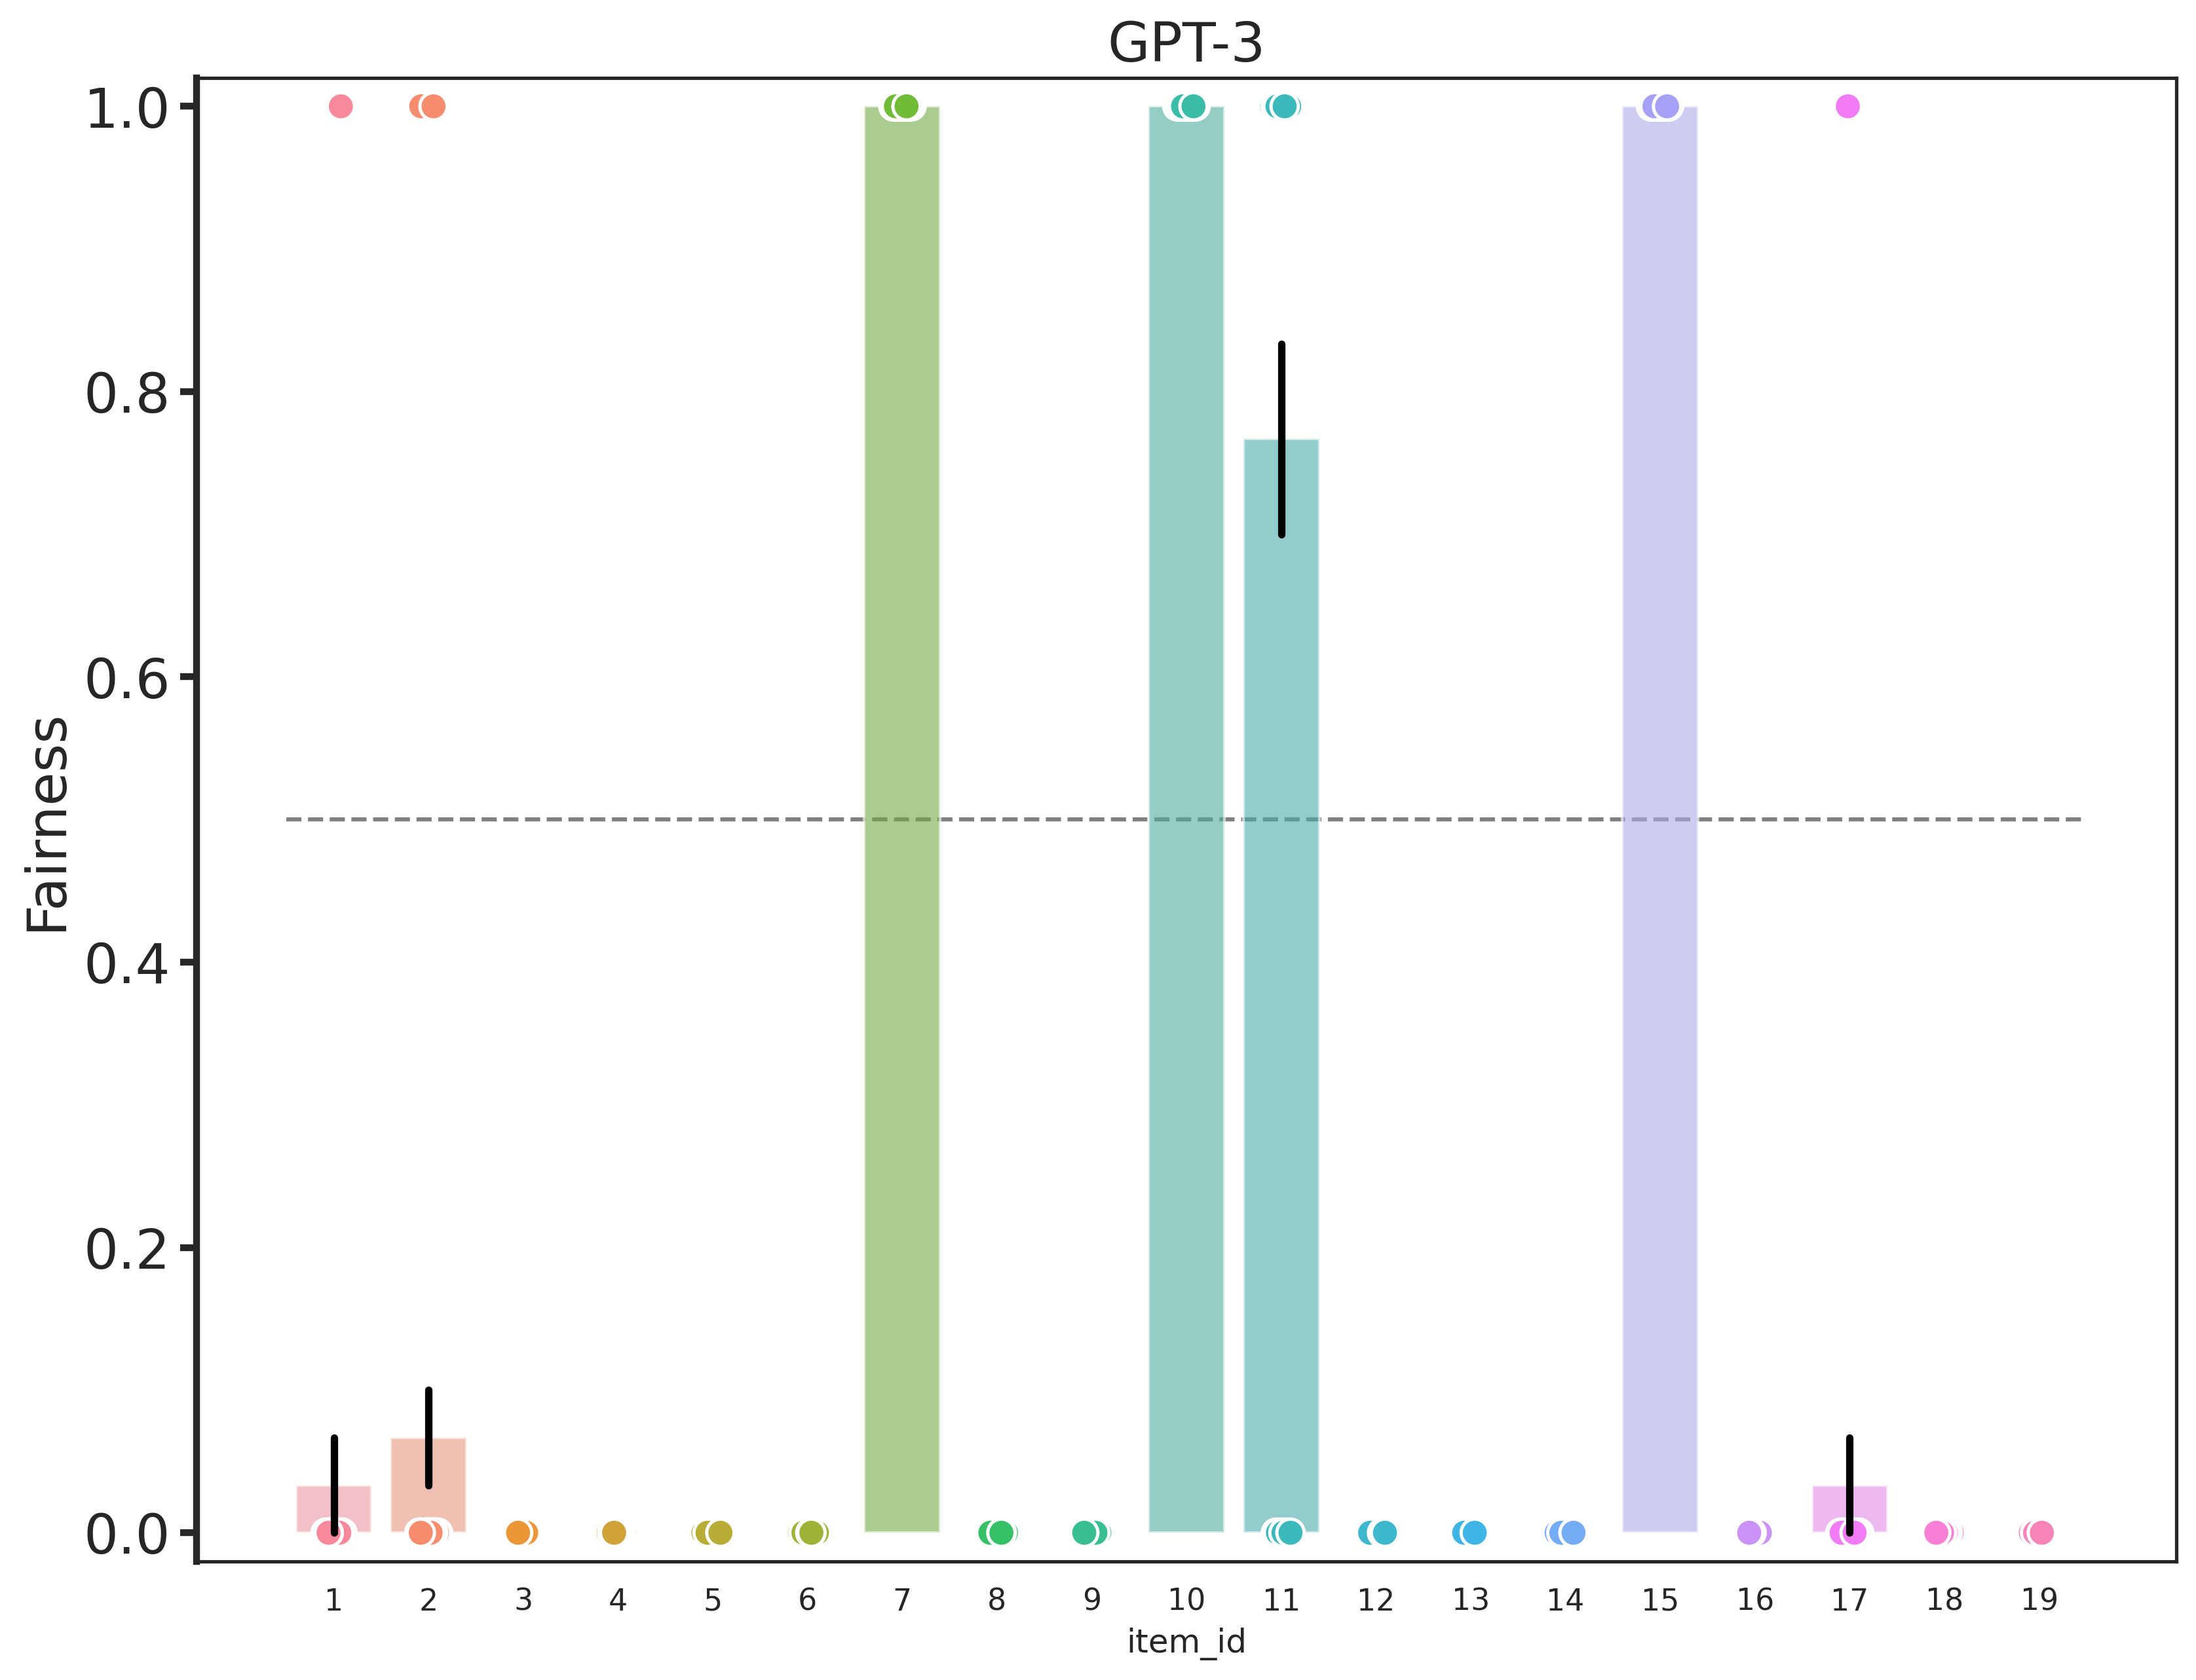

In [18]:
sns.set(rc={'figure.figsize':(13,10), "figure.dpi": 300, 'legend.fontsize': 20,  'xtick.labelsize': 11, 'ytick.labelsize': 20, 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'text.usetex': False})
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

plt.rcParams['ytick.major.width'] = 2.5


df = ds.gpt
#plt.subplot(1, 2, 1)
sns.barplot(x='item_id', y='fair', data=df, alpha=.6, errwidth=0, zorder=1)
sns.stripplot(x='item_id', y='fair', data=df, size=10, linewidth=1.2, zorder=2, edgecolor='white', jitter=True)
sns.pointplot(x='item_id', y='fair', data=df, color='black',  join=False, ci=68, linewidth=1, edgecolor='white', capsize=0, zorder=3, scale=0)
# raincloud(x='exp', y='yes', markersize=9, df=df)
x_lim = plt.gca().get_xlim()
plt.plot(x_lim, [.5, .5], ls='--', color='gray', zorder=0)
plt.ylim(-.02, 1.02)
plt.ylabel('Fairness', fontsize=20)
# plt.xticks(labels=order, ticks=[0, 1, 2])
plt.title('GPT-3', fontsize=20)
plt.tick_params(bottom=False)
plt.gca().spines['left'].set_linewidth(2.5)



ValueError: Could not interpret value `val` for parameter `x`

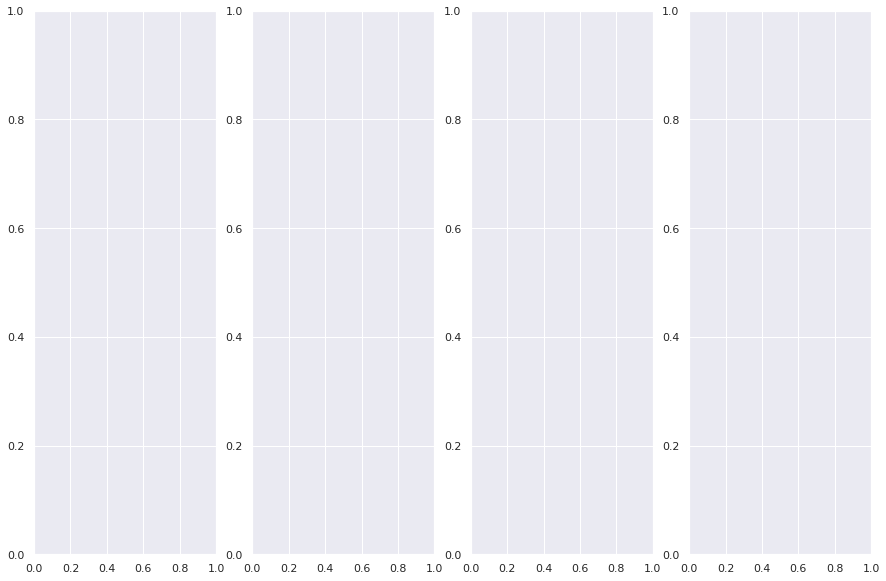

In [13]:
sns.set(rc={'figure.figsize':(15,10)})

exp = df['exp'].unique()
# df = df[df['unclear']!=1]
fig, axes = plt.subplots(nrows=1, ncols=len(exp))
# Draw a nested barplot by species and sex
for e, ax in zip(exp, axes.flat):
    sns.histplot(
        x='val', data=df[df['exp']==e], hue='val', hue_order=['yes', 'no', 'unclear'], stat='probability', alpha=.8, ax=ax)
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0, 11)/10)
    ax.set_title(e)
# sns.displot(x='val', data=df, col='exp', hue='val', stat='probability', alpha=.8)
# sns.displot(x='val', data=df, col='exp', hue='val', stat='probability', alpha=.8)